<a href="https://colab.research.google.com/github/on-kulyashov/RQC-projects/blob/main/fermions_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9 spins, negative field -> negative field (degenerate), small negative bonds -> big positive bonds (degenerate), real evolution, T = 0



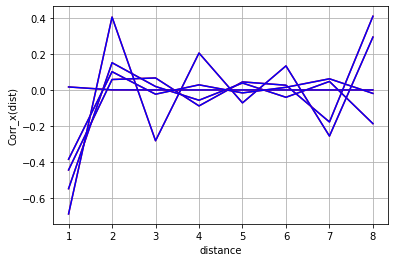

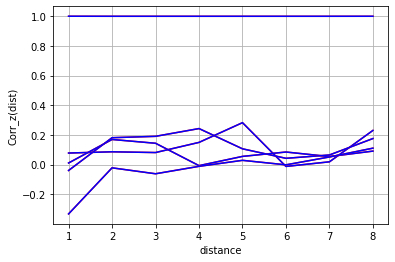

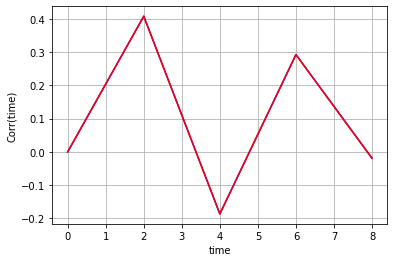

In [11]:
!pip install pfapack
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from pfapack import pfaffian as pf
import numpy.matlib

experiments = []
experiment = 5
with open('test_fermi.txt') as f:
    while(True):
        description = f.readline()
        if not description:
            break
        num_of_spins = int(f.readline())
        fields_1 = list(map(float, (f.readline()).split(", ")))
        interactions_1 = list(map(float, (f.readline()).split(", ")))
        fields_2 = list(map(float, (f.readline()).split(", ")))
        interactions_2 = list(map(float, (f.readline()).split(", ")))
        temperature = float(f.readline())
        experiments.append((description, num_of_spins, fields_1, interactions_1, fields_2, interactions_2, temperature))

description = experiments[experiment][0]
num_of_spins = experiments[experiment][1]
fields_1 = experiments[experiment][2]
interactions_1 = experiments[experiment][3]
fields_2 = experiments[experiment][4]
interactions_2 = experiments[experiment][5]
temperature = experiments[experiment][6]
time = np.arange(0, 10, 2)
print(description)

# direct solution
pauli = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ])
dbl_pauli = np.array([np.kron(sigma, sigma) for sigma in pauli])
 
# hamiltonian construction
def Hamiltonian(fields, interactions):
    '''
    as in Barouch(I), formula 2.1, where gamma = 1, mu = 1
    '''
    H = np.zeros(2**num_of_spins)
    for bond in range(num_of_spins - 1):
        H = H + 0.5 * interactions[bond] * np.kron(np.kron(np.eye(2**bond), dbl_pauli[0]), np.eye(2**(num_of_spins - 2 - bond)))
    for spin in range(num_of_spins):
        H = H - 0.5 * fields[spin] * np.kron(np.kron(np.eye(2**spin), pauli[2]), np.eye(2**(num_of_spins - 1 - spin)))
    return np.real_if_close(H) 
 
def direct_evolution(state, dt):
    u = expm(-1j * dt * Hamiltonian(fields_2, interactions_2))
    uH = np.conj(np.transpose(u))
    return np.matmul(u, np.matmul(state, uH))
 
def integrate(f, sol0, time):
    sol = [sol0]
    for moment in range(1, len(time)):
        sol.append(f(sol[-1], (time[moment] - time[moment - 1])))
    return sol
 
def initial_state_direct(temperature, hamilt):
    if temperature:
        dens_direct = expm(-hamilt / temperature)
        dens_direct = dens_direct / np.trace(dens_direct)
        return dens_direct
    else:
        energies_direct, eig_states_direct = np.linalg.eigh(hamilt)
        energies_direct = np.real_if_close(energies_direct)
        eig_states_direct = np.real_if_close(eig_states_direct)
        idx = np.argsort(energies_direct)
        energies_direct = energies_direct[idx]
        eig_states_direct = eig_states_direct[:,idx]
        return np.tensordot(eig_states_direct[:,0], np.transpose(eig_states_direct[:,0]), axes=0)
 
# correlator construction
def sigma(i, j, direction):
    if i - j:
        return np.real(np.kron(np.kron(np.kron(np.kron(np.eye(2**i), pauli[direction]), np.eye(2**(j-i-1))), pauli[direction]), np.eye(2**(num_of_spins - j - 1))))
    return np.eye(2**num_of_spins)
 
def s_direct(site_1_direct, site_2_direct, dens_direct, direction):
    '''
    calculates correlator(density matrix) between sites 1 and 2 in ascending order 
    '''
    fst_site_direct = min(site_1_direct, site_2_direct)
    snd_site_direct = max(site_1_direct, site_2_direct)
    return np.trace(np.matmul(dens_direct, sigma(fst_site_direct, snd_site_direct, direction)))
 
# Barouch's solution
 
def hamiltonian(fields, interactions):
    '''
    calculates hamiltonian from field and bonds values
    as in Barouch(I), formula 2.4
    '''
    mid = np.zeros((num_of_spins, num_of_spins))
    up = np.zeros((num_of_spins, num_of_spins))
    dn = np.zeros((num_of_spins, num_of_spins))
    for position in range(num_of_spins):
        mid[position][position] = float(fields[position]) / 2
    for position in range(num_of_spins - 1):
        up[position][position + 1] = float(interactions[position]) / 4
        dn[position + 1][position] = float(interactions[position]) / 4
    a = (mid - up - dn)
    b = -(up - dn)
    return np.block([[- a, - b], [b, a]])
 
def gamma(old_occ_nums, old2new):
    '''
    calculates new occupation numbers (icluding cross-terms) at time = 0 
    from initial (old) occupation numbers
    '''
    return np.matmul(old2new, np.matmul(old_occ_nums, np.transpose(old2new)))

def gamma_t(energies, time):
    '''
    calculates new matrix_ij = <gamma_i gamma_j> at a given time
    energies = (e1, ..., en, ) - all positive eigenvals of ham (energy/2)
    old2new - transfer matrix: (g1 ... g1^T ...)_old = old2new * (g1 ... g1^T ...)_new
    evolution is driven by multiplying by exponent of the sum of corresponding energies
    '''
    return gamma_precalc * np.array([[np.exp(-2j*(energies[fst_g_ind] + energies[snd_g_ind]) * time) for fst_g_ind in range(2 * num_of_spins)] for snd_g_ind in range(2 * num_of_spins)])
 
def c_ij_t(newU, energies, time):
    '''
    calculates c-correlators from gamma(new)-correlators
    '''
    # return np.matmul(newU, np.matmul(gamma_t(energies, time), np.transpose(newU)))[fst_c_ind, snd_c_ind]
    return np.matmul(newU, np.matmul(gamma_t(energies, time), np.transpose(newU)))

def sub_mat(c_ij_t_precalc, p, q, sub_mat_type):
    '''
    constructs submatrices S, G, Q from c-correlators
    p, q are sites for which correlator is calculated
    '''
    if sub_mat_type == 'S':
        signs = np.array([1,-1,-1,1])
    elif sub_mat_type == 'G':
        signs = np.array([1,1,-1,-1])
    elif sub_mat_type == 'Q':
        signs = np.array([1,1,1,1])
    def elem(l, m):
        if (sub_mat_type == 'S' or sub_mat_type == 'Q') and l == m:
            return 0
        cln_cmn = c_ij_t_precalc[l + num_of_spins, m + num_of_spins]
        cl_cm = c_ij_t_precalc[l, m]
        cln_cm = c_ij_t_precalc[l + num_of_spins, m]
        cl_cmn = c_ij_t_precalc[l, m + num_of_spins]
        return np.matmul(signs, np.array([cln_cmn, cln_cm, cl_cmn, cl_cm]))
    submt = np.array([[elem(a, b) for b in range(p, q)] for a in range(p, q)])
    return submt
    
def rho_x(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    S = S_whole[0:site, 0:site]
    Q = Q_whole[1:(site + 1), 1:(site + 1)]
    G = G_whole[0:site, 1:(site + 1)]
    R_x = np.block([[S, G], [-np.transpose(G), Q]])
    return ((-1)**(site * (site - 1) / 2)) * pf.pfaffian((R_x - np.transpose(R_x)) / 2)

def eig_energies_states(ham):
    '''
    returns e - eigenenrgies of ham: e1, e2, ... -e1, -e2, ... and
    u - transfer: gamma = u * c
    '''
    e, u = np.linalg.eigh(ham)
    idx = np.argsort(e)[::-1]
    e = e[idx]
    e = np.concatenate((e[:num_of_spins], e[-1:num_of_spins - 1:-1]))
    u = u[:,idx]
    u = np.concatenate((u[:,:num_of_spins], u[:,-1:num_of_spins-1:-1]), axis=1)
    u1 = u[:num_of_spins, :num_of_spins]
    u2 = u[num_of_spins:, :num_of_spins]
    u = np.block([[u1, u2], [u2, u1]])
    return (e, u)

def rho_z(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    def submat_z(submat_whole):
        return np.array([[submat_whole[0, 0], submat_whole[0, site]],[submat_whole[site, 0], submat_whole[site, site]]])
    S_z = submat_z(S_whole)
    Q_z = submat_z(Q_whole)
    G_z = submat_z(G_whole)
    R_z = np.block([[S_z, G_z], [-np.transpose(G_z), Q_z]])
    return -np.real_if_close(pf.pfaffian((R_z - np.transpose(R_z)) / 2))

def oc_num_0(temperature, e):
    '''
    from temperature and initial energies calculates
    initial (old) occupation numbers (gamma^dagger gamma)
    '''
    if temperature == 0:
        nums = np.zeros(num_of_spins)
    else:
        nums = (1 / (1 + np.exp(2 * e[:num_of_spins] / temperature)))
    return np.block([[np.zeros((num_of_spins, num_of_spins)), np.diag(1 - nums)], [np.diag(nums), np.zeros((num_of_spins, num_of_spins))]])

'''
precalculate values for reuse
gamma_new = old2new * gamma_old
'''
energies_old, c2g_old = eig_energies_states(hamiltonian(fields_1, interactions_1))
energies_new, c2g_new = eig_energies_states(hamiltonian(fields_2, interactions_2))
oc_num_0_precalc = oc_num_0(temperature, energies_old)
old2new_precalc = np.matmul(np.transpose(c2g_new), c2g_old)
gamma_precalc = gamma(oc_num_0_precalc, old2new_precalc)

'''
correlators construction
'''
correlations_x = []
correlations_z = []
for time_moment in time:
    corr_fix_time_x = []
    corr_fix_time_z = []
    c_ij_t_precalc = c_ij_t(c2g_new, energies_new, time_moment)
    S_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'S')
    Q_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'Q')
    G_precalc = sub_mat(c_ij_t_precalc, 0, num_of_spins, 'G')
    for site in range(num_of_spins):
        if site == 0:
            corr_fix_time_x.append(1)
            corr_fix_time_z.append(1)
        else:
            corr_fix_time_x.append(rho_x(S_precalc, Q_precalc, G_precalc, site))
            corr_fix_time_z.append(rho_z(S_precalc, Q_precalc, G_precalc, site))
    correlations_x.append(corr_fix_time_x)
    correlations_z.append(corr_fix_time_z)
correlations_x = np.real_if_close(np.transpose(np.array(correlations_x)))
correlations_z = np.real_if_close(np.transpose(np.array(correlations_z)))

dist = np.arange(num_of_spins)
dens_evol = integrate(direct_evolution, initial_state_direct(temperature, Hamiltonian(fields_1, interactions_1)), time)
dens0 = dens_evol[0]
correlations_direct_x = np.array([[np.real_if_close(s_direct(0, x, dens, 0)) for dens in dens_evol] for x in range(num_of_spins)])
correlations_direct_z = np.array([[np.real_if_close(s_direct(0, x, dens, 2)) for dens in dens_evol] for x in range(num_of_spins)])
for t in range(len(time)):
    plt.plot(dist[1:], np.real_if_close(correlations_x[:,t], tol=1000)[1:], 'r-', label="fast")
    plt.plot(dist[1:], np.real_if_close(correlations_direct_x[:,t], tol=1000)[1:], 'b-', label="direct")
plt.xlabel("distance")
plt.ylabel("Corr_x(dist)")
# plt.legend()
plt.grid()
plt.show()

for t in range(len(time)):
    plt.plot(dist[1:], np.real_if_close(correlations_z[:,t], tol=1000)[1:], 'r-', label="fast")
    plt.plot(dist[1:], np.real_if_close(correlations_direct_z[:,t], tol=1000)[1:], 'b-', label="direct")
plt.xlabel("distance")
plt.ylabel("Corr_z(dist)")
# plt.legend()
plt.grid()
plt.show()
 
plt.plot(time, np.real_if_close(correlations_direct_x[num_of_spins-1,:]), 'b-')
plt.plot(time, np.real_if_close(correlations_x[num_of_spins-1,:]), 'r-')
plt.xlabel("time")
plt.ylabel("Corr(time)")
plt.grid()
plt.show()
